In [1]:
%reload_ext autoreload

import numpy as np
from scipy.optimize import least_squares
from numpy.linalg import inv
import matplotlib.pyplot as plt

import topocalib
from topocalib.layout import generate_layout, show_layout
from topocalib.model_cv import ls_func, array2params, get_pixel_coordinates, get_pixel_coordinates_test

get_pixel_coordinates_test()

array([[ 891.26175995],
       [1007.83078454]])

Rotation matrix is changed, change it!

Generating translations of the cameras
\begin{equation*}
f_R(\alpha, \beta, \kappa) = \begin{pmatrix}
            1 & 0 & 0 \\
            0 & cos(\alpha) & -sin(\alpha) \\
            0 & sin(\alpha) & cos(\alpha)
        \end{pmatrix}\begin{pmatrix}
            cos(\beta) & 0 & sin(\beta) \\
            0 & 1 & 0 \\
            -sin(\beta) & 0 & cos(\beta)
        \end{pmatrix}\begin{pmatrix}
            cos(\kappa) & -sin(\kappa) & 0 \\
            sin(\kappa) & cos(\kappa) & 0 \\
            0 & 0 & 1 \\
        \end{pmatrix}
\\
T = \begin{pmatrix}
    0 \\
    0 \\
    d
\end{pmatrix} f_R(0, slope, angle_i)
\end{equation*}
Where $ d $ is a distance between camera and origin, $ f_R $ function that gives rotation matrix based on rotation angles.

For rotation we first determine x, y and z one vectors as following
\begin{equation*}
\vec{z} = \frac{T}{||T||}
\\
\vec{x} = \begin{pmatrix}
    \begin{pmatrix}
        cos(\theta) & -sin(\theta) \\
        sin(\theta) & cos(\theta)
    \end{pmatrix} *
    \begin{pmatrix}
        0 \\
        1
    \end{pmatrix} \\
    0
\end{pmatrix}
\\
\vec{y} = \vec{x} \times \vec{z}
\end{equation*}

Then we construct rotation matrix ($ R $) and extract Euler angles in vector $r$ with 3 rotation angles
\begin{equation*}
R = \begin{pmatrix}
    \vec{x}_0 & \vec{y}_0 & \vec{z}_0 \\
    \vec{x}_1 & \vec{y}_1 & \vec{z}_1 \\
    \vec{x}_2 & \vec{y}_2 & \vec{z}_2
\end{pmatrix}
\\
f_R^{-1}= \begin{cases}
    R_{1,3} < 1 \land R_{1,3} > -1 & \begin{pmatrix}
        atan(\frac{- R_{2,3}}{R_{3,3}}) \\
        asin({R_{13}}) \\
        atan(\frac{- R_{1,2}}{R_{1,1}})
    \end{pmatrix} \\
    R_{1,3} < 1 \land R_{1,3} = -1 & \begin{pmatrix}
        - atan(\frac{R_{2,1}}{R_{2,2}}) \\
        - \pi / 2 \\
        0
    \end{pmatrix} \\
    R_{1,3} = 1 & \begin{pmatrix}
        - atan(\frac{R_{2,1}}{R_{2,2}}) \\
        + \pi / 2 \\
        0
    \end{pmatrix}
\end{cases}
\\
r = f_R^{-1}(R)
\end{equation*}

T = [[-2.5         0.          4.33012702]]	| R = [[-0.         -0.52359878  1.57079633]]
T = [[-1.55402492  1.95831727  4.33012702]]	| R = [[-0.42472677 -0.31603984  0.60210768]]
T = [[0.56800524 2.43461908 4.33012702]]	| R = [[-0.51220043  0.11384682 -0.19936285]]
T = [[2.26018036 1.0684497  4.33012702]]	| R = [[-0.24191552  0.46904661 -1.07113806]]
T = [[ 2.24189604 -1.10630111  4.33012702]]	| R = [[ 0.25013835  0.46495123 -2.08871864]]
T = [[ 0.5269895  -2.44382529  4.33012702]]	| R = [[ 0.51381438  0.10559402 -2.95696857]]
T = [[-1.58673219 -1.93191122  4.33012702]]	| R = [[ 0.41965248 -0.32292997  2.5233292 ]]


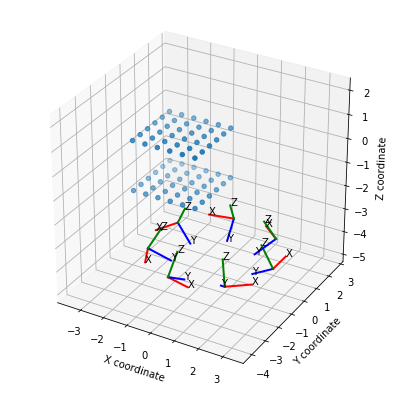

In [2]:
%matplotlib inline
%autoreload

Ts, Rs, X_ws = generate_layout(slope=np.pi/6, step=0.9, nplains=2, distance=5, plainsize=(6, 6), planetransl=[-1, -4, 0])

for X_w, T, R in zip(X_ws, Ts, Rs):
    #T += np.random.normal(scale=0.2, size=3)
    #R += np.random.normal(scale=0.01, size=3)
    print('T = %s\t| R = %s' % (T, R))

show_layout(Ts, Rs, X_ws)

# Generate projections in image frame
ks = [0.0, 0.0, 0.0]
C = [800] 
center = [1400, 1400]
X_cs = []


for X_w, T, R in zip(X_ws, Ts, Rs):
    T = T.A1
    R = R.A1
    arr = np.empty([0, 2])
    for point in X_w:
        px = get_pixel_coordinates(T, R, point, ks, C, center)
        arr = np.append(arr, px.T, axis=0)
    X_cs.append(arr)

In [3]:
import cv2


N_OK = len(X_cs)
K = np.zeros((3, 3))
D = np.zeros((4, 1))
rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]

cvX_ws = X_ws.copy()
cvX_cs = X_cs.copy()
for i in range(len(X_ws)):
    n_points = X_ws[0].shape[0]
    cvX_ws[i] = X_ws[i].reshape(1, n_points, 3)
    cvX_cs[i] = X_cs[i].reshape(n_points, 1, 2)

# https://docs.opencv.org/master/db/d58/group__calib3d__fisheye.html#gad626a78de2b1dae7489e152a5a5a89e1
retval, K, D, rvecs, tvecs = \
    cv2.fisheye.calibrate(
        cvX_ws,
        cvX_cs,
        (2800, 2800),
        K,
        D,
        rvecs,
        tvecs,
        cv2.fisheye.CALIB_CHECK_COND+cv2.fisheye.CALIB_FIX_SKEW+cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC + cv2.fisheye.CALIB_FIX_K2 + cv2.fisheye.CALIB_FIX_K3 + cv2.fisheye.CALIB_FIX_K4 ,
        (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1000, 1e-9)
    )

print('retval = %s' % retval)
print('K = %s' % K)
print('D = %s' % D)
print('rvecs = %s' % rvecs)
print('tvecs = %s' % tvecs)

retval = 1.638438069389739e-10
K = [[8.0e+02 0.0e+00 1.4e+03]
 [0.0e+00 8.0e+02 1.4e+03]
 [0.0e+00 0.0e+00 1.0e+00]]
D = [[5.98530808e-14]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]]
rvecs = [array([[-0.41038024],
       [-0.41038024],
       [ 1.53155991]]), array([[-0.50363927],
       [-0.17555233],
       [ 0.65517021]]), array([[-0.52128342],
       [ 0.06000295],
       [-0.22393407]]), array([[-0.46626362],
       [ 0.29532149],
       [-1.1021548 ]]), array([[-0.32903494],
       [ 0.52928372],
       [-1.97531372]]), array([[-0.0809832 ],
       [ 0.7597244 ],
       [-2.83533007]]), array([[-0.22867095],
       [-0.63870222],
       [ 2.38366913]])]
tvecs = [array([[-2.50000000e+00],
       [ 7.75921857e-13],
       [ 4.33012702e+00]]), array([[-1.55402492],
       [ 1.95831727],
       [ 4.33012702]]), array([[0.56800524],
       [2.43461908],
       [4.33012702]]), array([[2.26018036],
       [1.0684497 ],
       [4.33012702]]), array([[ 2.24189604],
       [-1.1

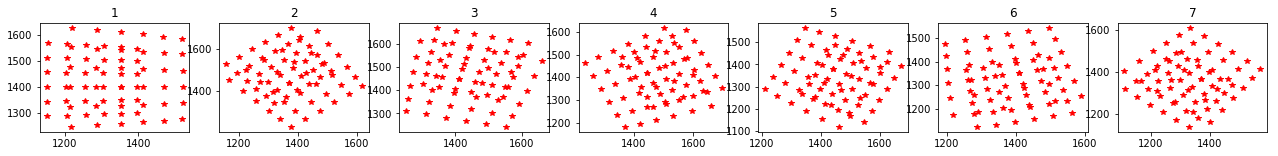

In [4]:
%matplotlib inline

N = len(X_cs)
fig, ax = plt.subplots(1, N, figsize=(22, 2))
for i in range(N):
    ax[i].plot(X_cs[i][:, 0], X_cs[i][:, 1], 'r*', label='Ground truth')
    ax[i].set_title(i + 1)

In [5]:
%autoreload

from scipy.optimize import minimize, lsq_linear, root
from topocalib.model_cv import ls_func_cost, ls_func2
from time import time

ks = [0.0, 0.0, 0.0]
center = [1400, 1400]
T = [ 1,  1, 5 ]
R = [ 0.1, 0.1,  0.1 ]
C = [800]

x0 = ks + C + center
rotation_translation_bounds = [[-np.inf, -np.inf, -np.inf, -np.pi, -np.pi, -np.pi],
             [np.inf, np.inf, np.inf, np.pi, np.pi, np.pi]]
bounds = [
    [-0.1, -0.1, -0.1, -np.inf, center[0] * 0.8, center[1] * 0.8],
    [0.1, 0.1, 0.1, np.inf, center[0] * 1.2, center[1] * 1.2] 
]
diff_step = [0.001, 0.001, 0.001, 1, 1, 1 ]


n_core_params = len(x0)
n_points = X_cs[0].shape[0] * X_cs[0].shape[1]
n_images = len(X_cs)
n_params = n_core_params + n_images * 6

jac_sparsity = np.zeros((n_images * n_points, n_params))

for i in range(0, n_images):
    jac_sparsity[i*n_points:(i+1)*n_points, 0:n_core_params] = None
    jac_sparsity[i*n_points:(i+1)*n_points, (n_core_params+i*6):(n_core_params+i*6+6)] = None
    
print(jac_sparsity)


for objps, corners in zip(X_ws, X_cs):
    bounds[0] += rotation_translation_bounds[0]
    bounds[1] += rotation_translation_bounds[1]
    x0 += T + R
    diff_step += [ 1, 1, 1, 0.01, 0.01, 0.01 ]




tic = time()
res = least_squares(ls_func2, np.array(x0), args=(X_ws, X_cs), jac_sparsity=jac_sparsity, tr_solver='lsmr', x_scale='jac', max_nfev=50)
# res = root(ls_func2, np.array(x0), args=(X_ws, X_cs), method='lm', options={'maxiter': 1000, 'xtol': 0.0001 })
# res = minimize(ls_func_cost, np.array(x0), args=(X_ws, X_cs), options={'maxiter': 100})
print(f'Taken {time() - tic} seconds')

jacobian = res.jac
K_all, D_all, R_all, T_all = array2params(res.x)
C = res.x[3]
center = res.x[4:6]
ks = res.x[0:3]
print(f'T = {T_all}')
print(f'R = {R_all}')
print('')
print(res.x)
# print(res)

[[nan nan nan ...  0.  0.  0.]
 [nan nan nan ...  0.  0.  0.]
 [nan nan nan ...  0.  0.  0.]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Taken 21.801913261413574 seconds
T = [array([-2.50012400e+00,  6.76889838e-05,  4.33008388e+00]), array([-1.55414818,  1.95837864,  4.33008222]), array([0.56787864, 2.43467742, 4.33013381]), array([2.26005047, 1.06850737, 4.33019958]), array([ 2.24176194, -1.10624216,  4.33022982]), array([ 0.52685326, -2.4437604 ,  4.33020156]), array([-1.58686314, -1.931841  ,  4.33013629])]
R = [array([-1.24755819e-05, -5.23630259e-01,  1.57079535e+00]), array([-0.42474582, -0.31606946,  0.60209403]), array([-0.51221619,  0.11381976, -0.19937733]), array([-0.24192981,  0.46902006, -1.07114547]), array([ 0.25012081,  0.46492643, -2.08871314]), array([ 0.5138013 ,  0.10557023, -2.95695767]), array([ 0.41964508, -0.32295716,  2.52333968])]

[ 7.26250520e-03 -1.14449214e-01  5.17275234e-01  7.99908553e+02
  1.40002

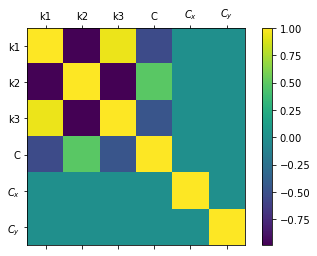

[[ 1.00000000e+00 -9.77672967e-01  9.38744751e-01 -5.33781911e-01
  -3.54885491e-05  2.64589697e-05]
 [-9.77672967e-01  1.00000000e+00 -9.89159686e-01  4.93024345e-01
   1.27508648e-06 -2.35330638e-05]
 [ 9.38744751e-01 -9.89159686e-01  1.00000000e+00 -4.61866629e-01
   1.00606214e-05  2.41616970e-05]
 [-5.33781911e-01  4.93024345e-01 -4.61866629e-01  1.00000000e+00
   2.14653520e-04  7.15196741e-05]
 [-3.54885393e-05  1.27507600e-06  1.00606321e-05  2.14653516e-04
   1.00000000e+00  1.79724817e-04]
 [ 2.64589662e-05 -2.35330606e-05  2.41616941e-05  7.15196751e-05
   1.79724815e-04  1.00000000e+00]]


In [6]:
%matplotlib inline

# Calaculate convariance matrix
cov = inv((jacobian.T * jacobian).todense())

# Normalise covariance matrix
nm = np.diag(np.power(np.diag(cov), -0.5))
corr = nm * cov * nm

# Visualise
names = ['', 'k1', 'k2', 'k3', 'C', '$C_x$', '$C_y$']
corr = corr[0:6, 0:6]
fig, ax = plt.subplots()
cax = ax.matshow(corr)
fig.colorbar(cax)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()
print(corr)

(72, 2)


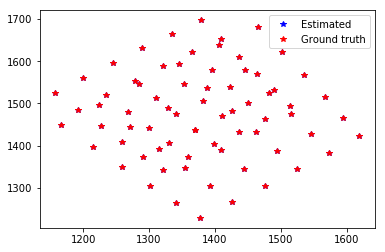

In [7]:
%matplotlib inline
IMG_ID = 1

estimated = np.empty([0, 2])
for point in X_ws[IMG_ID]:
    X_c = get_pixel_coordinates(T_all[IMG_ID], R_all[IMG_ID], point, ks, C, center)
    estimated = np.append(estimated, np.transpose(X_c), axis=0)
    

print(X_cs[IMG_ID].shape)
plt.plot(estimated[:, 0], estimated[:, 1], 'b*', label='Estimated')
plt.plot(X_cs[IMG_ID][:, 0], X_cs[IMG_ID][:, 1], 'r*', label='Ground truth')
plt.legend()

(array([10.,  7., 11.,  7.,  8., 12.,  8.,  4.,  4.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.00038465, 0.00105216, 0.00171967, 0.00238719, 0.0030547 ,
        0.00372221, 0.00438972, 0.00505724, 0.00572475, 0.00639226,
        0.00705977, 0.00772729, 0.0083948 , 0.00906231, 0.00972982,
        0.01039733, 0.01106485, 0.01173236, 0.01239987, 0.01306738,
        0.0137349 ]),
 <a list of 20 Patch objects>)

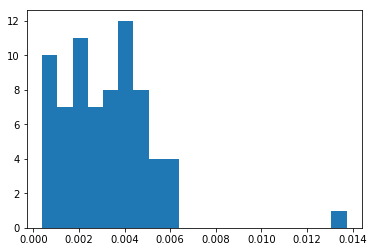

In [8]:
# Plot histogram of residuals

resid = X_cs[IMG_ID] - estimated
resid_dist = np.sqrt(resid[:, 0]**2 + resid[:, 1]**2)
plt.hist(resid_dist, bins=20)